# Hands on session: Analysis of Higgs data

In [1]:
%reload_ext custom_magics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from custom_functions import *

In [3]:
num_workers=5
spark=%sc $num_workers

from pyspark.sql import SparkSession
spark_session = SparkSession(spark)

#check if spark is there
spark

<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-eleoracca>

## Prepare the input data

In [4]:
#read input dataset from parquet

inputFile = 'hdfs://192.168.2.39/data/Higgs10M.parquet'
#inputFile = 'hdfs://192.168.2.39/data/Higgs1M.parquet'
#inputFile = 'hdfs://192.168.2.39/data/Higgs100k.parquet' 
#other files are: Higgs1M.parquet, Higgs100k.parquet

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

CPU times: user 1.95 ms, sys: 2.97 ms, total: 4.91 ms
Wall time: 5.1 s


In [5]:
total_events = df.count()

print('There are '+str(total_events)+' events')

There are 9560096 events


### QUESTION 1: is the dataset unbalanced? Do we need undersampling?

I think the dataset is slightly imbalanced towards the events with label 1, but the number of data for each label is pretty similar. For this reason I don't think we will incur in problems of imbalanced datasets.

As I don't think there really is a problem with imbalanced datasets, I don't think we need to resample them with undersampling techniques.

| Sample | Data with label 0 | Data with label 1 |
| :-: | :-: | :-: |
| Higgs10M | 4494163 | 5065933 |
| Higgs1M | 460646 | 518873 |
| Higgs100k | 47166 | 52833 |

In [6]:
# motivate your answer here

In [7]:
# counting the occurrences of lables 1 and 0 in the dataset
print('Number of data with label 0: ', df.where(df.label == 0.0).count())
print('Number of data with label 1: ', df.where(df.label == 1.0).count())

Number of data with label 0:  4494163
Number of data with label 1:  5065933


### QUESTION 2: Split the dataset into 5 parts with random events

In [8]:
#your answer goes here

In [9]:
split1, split2, split3, split4, split5 = df.randomSplit([0.1, 0.3, 0.3, 0.2, 0.1])

print('Number of data in split1', split1.count())
print('Number of data in split2', split2.count())
print('Number of data in split3', split3.count())
print('Number of data in split4', split4.count())
print('Number of data in split5', split5.count())

Number of data in split1 954732
Number of data in split2 2869278
Number of data in split3 2870442
Number of data in split4 1910226
Number of data in split5 955418


### QUESTION 3: split the dataset for training and test

In [10]:
# your answer goes here
# split into two dataframes called training and test

In [11]:
training, test = df.randomSplit([0.75,0.25])

#### Create the input feature vector

Documentation on how to do data preprocessing in Spark: https://spark.apache.org/docs/latest/ml-features.html

In [12]:
feature = training.columns
feature.remove('label')

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature, outputCol='features')

training = assembler.transform(training)
test = assembler.transform(test)

## ML with pyspark

Try to solve the signal vs background classification problem using a new algorithm of your choice (obviously, not GBT or MCP)
Documentation at: https://spark.apache.org/docs/2.2.0/ml-classification-regression.html

In [13]:
from pyspark.ml.classification import *
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [14]:
# your answer goes here

In [15]:
lsvc = LinearSVC(labelCol='label', featuresCol='features', maxIter=10, regParam=0.1)

Let's fit the model on the **training dataset**:

In [16]:
# your answer goes here

In [17]:
%%time
lsvc_model = lsvc.fit(training)

CPU times: user 17.8 ms, sys: 8.61 ms, total: 26.4 ms
Wall time: 28.5 s


#### QUESTION 4: Compute the accuracy on the test dataset

In [18]:
#your answer goes here

In [19]:
prediction = lsvc_model.transform(test)
prediction.head()

In [21]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")

print("Test set AUC = " + str(evaluator.evaluate(prediction)))

Test set AUC = 0.6576913230210126


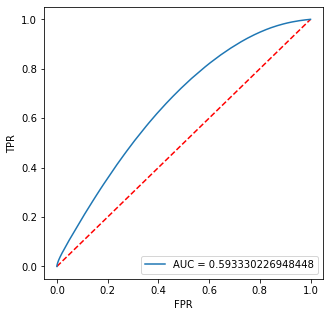

In [22]:
import matplotlib.pyplot as plt
from sklearn import metrics

#make ROC curve
roc = lsvc_model.summary().roc
fpr = np.asarray(roc.select('FPR').collect())
tpr = np.asarray(roc.select('TPR').collect())

y_pred = np.asarray(prediction.select('prediction').collect())
y_true = np.asarray(prediction.select('label').collect())

auc = metrics.roc_auc_score(y_true, y_pred)

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label = "AUC = " + str(auc))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.show()

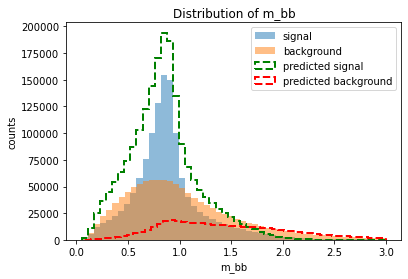

In [23]:
plotSignalvsBgWithPrediction(test, prediction, 'm_bb')

#### QUESTION 5: Are we over/under-fitting the data? How could the accuracy be improved?

In [24]:
#your answer goes here

In [25]:
train_prediction = lsvc_model.transform(training)
print("Training set AUC = " + str(evaluator.evaluate(train_prediction)))
print("Test set AUC = " + str(evaluator.evaluate(prediction)))

Training set AUC = 0.6577439936991882
Test set AUC = 0.6576914198606136


As the AUC for the training set and for the test set are very similar, it seems that the model is not over- or underfitting the data.

The accuracy can be improved by selecting appropriate values for the hyperparameters regParam and maxIter.

#### Hyperparameter tuning

We use the *spark_sklearn.grid_search* method.

In [26]:
subSample = training.sample(fraction=1.0/10, withReplacement=False).cache()
print('We will use',subSample.count(),' events for the grid search.')

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator=BinaryClassificationEvaluator(metricName='areaUnderROC')

lsvc = LinearSVC(labelCol='label', featuresCol='features', maxIter=10, regParam=0.1, tol=1e-8)

#choose hyperparameter space
regressionParam = np.logspace(-7, -3, num = 15)
iteration = np.linspace(10, 30, num = 3)
paramGrid = ParamGridBuilder().addGrid(lsvc.regParam, regressionParam).addGrid(lsvc.maxIter, iteration).build()

We will use 718163  events for the grid search.


In [31]:
print(regressionParam)

[1.00000000e-07 1.93069773e-07 3.72759372e-07 7.19685673e-07
 1.38949549e-06 2.68269580e-06 5.17947468e-06 1.00000000e-05
 1.93069773e-05 3.72759372e-05 7.19685673e-05 1.38949549e-04
 2.68269580e-04 5.17947468e-04 1.00000000e-03]


##### QUESTION 6: Compare n k-cross validator vs TrainValidation split methods 

In [27]:
#your answer goes here

In [28]:
%%time 
tvs = TrainValidationSplit(estimator=lsvc, estimatorParamMaps=paramGrid, evaluator=evaluator, trainRatio=0.8)

bestModel = tvs.fit(subSample)

print('regParam = '+str(bestModel.bestModel._java_obj.getRegParam()))
print('maxIter = '+str(bestModel.bestModel._java_obj.getMaxIter()))

test_prediction = bestModel.transform(test)
train_prediction = bestModel.transform(training)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")

print("Test  set AUC = " + str(evaluator.evaluate(test_prediction)))
print("Train set AUC = " + str(evaluator.evaluate(train_prediction)))

regParam = 1.9306977288832496e-05
maxIter = 20
Test  set AUC = 0.6836290359052117
Train set AUC = 0.683633775519311
CPU times: user 1.52 s, sys: 617 ms, total: 2.14 s
Wall time: 5min 53s


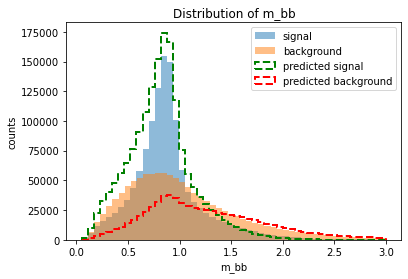

In [29]:
plotSignalvsBgWithPrediction(test, test_prediction, 'm_bb')

In [30]:
%%time 
cv = CrossValidator(estimator=lsvc, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=10, parallelism=num_workers)

bestModel = cv.fit(subSample)

print('regParam = '+str(bestModel.bestModel._java_obj.getRegParam()))
print('maxIter = '+str(bestModel.bestModel._java_obj.getMaxIter()))

test_prediction = bestModel.transform(test)
train_prediction = bestModel.transform(training)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")

print("Test  set AUC = " + str(evaluator.evaluate(test_prediction)))
print("Train set AUC = " + str(evaluator.evaluate(train_prediction)))

regParam = 1e-07
maxIter = 30
Test  set AUC = 0.6835798304792311
Train set AUC = 0.6835814420754579
CPU times: user 15.6 s, sys: 6.58 s, total: 22.2 s
Wall time: 44min 16s


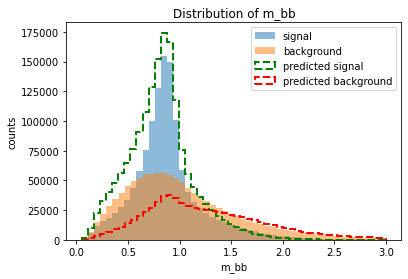

In [32]:
plotSignalvsBgWithPrediction(test, test_prediction, 'm_bb')

#### QUESTION 7: do you get a better accuracy? Why? Are you over/underfitting?

There isn't a problem of over- or underfitting as the AUC of the train and the test sets are similar with both the k-fold cross validator and the train validator.

The accuracy is only slighted improved: it may be necessary to further improve the search for the right parameters using other grids. It is also possible that this algorithm is not efficient in discriminating these events, so it may be useful to try another algorithm.

| Model | Training set AUC | Test set AUC |
| :-: | :-: | :-: |
| no validation | 0.6564022343586368 | 0.6565433950801117 |
| k-fold cross validator | 0.683633775519311 | 0.6836290359052117 |
| train validator | 0.6835798304792311 | 0.6835814420754579 |

In [33]:
# When you're done, stop spark
spark.stop()

#### QUESTION 8

pick any two models (can be any from pyspark MLLib, Keras Sequential, BigDL sequential) and:
- compare them in terms of performances (you can use results from previous days)
- compare how they scale in terms of performances and training time when you change the number of executors (for example, from 1 to 5)
- discuss the results

In [37]:
import time
import array

worker = 7

spark=%sc $worker
spark_session = SparkSession(spark)

# import and preprocessing of the data
inputFile = 'hdfs://192.168.2.39/data/Higgs10M.parquet'
df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

training, test = df.randomSplit([0.75,0.25])

feature = training.columns
feature.remove('label')
assembler = VectorAssembler(inputCols=feature, outputCol='features')

training = assembler.transform(training)
test = assembler.transform(test)

# GBT Model
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=20, maxDepth=5)

start_gbt = time.time()

gbt_model = gbt.fit(training)

end_gbt = time.time()
time_gbt = end_gbt - start_gbt

gbt_test_prediction = gbt_model.transform(test)
gbt_training_prediction = gbt_model.transform(training)

evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")

# MCP Model
layers = [28, 30, 30, 2]
mpc = MultilayerPerceptronClassifier(labelCol='label', featuresCol='features', maxIter=100, layers=layers, blockSize=128, seed=24)

start_mpc = time.time()

mpc_model = mpc.fit(training)

end_mpc = time.time()
time_mpc = end_mpc - start_mpc

mpc_test_prediction = mpc_model.transform(test)
mpc_training_prediction = mpc_model.transform(training)

print("GBT: Time = ", time_gbt, "\n     AUC =  ", evaluator.evaluate(gbt_test_prediction))
print("MCP: Time = ", time_mpc, "\n     AUC =  ", evaluator.evaluate(mpc_test_prediction))

spark.stop()

GBT: Time =  75.75706839561462 
     AUC =   0.7805370540609292
MCP: Time =  132.6515338420868 
     AUC =   0.731770032906414


In [46]:
gbt_times = [167.34393000602722, 118.4838228225708, 108.58140110969543, 98.35930967330933, 83.87632656097412, 77.35144543647766, 75.75706839561462]
gbt_accuracy = [0.7810099563941507, 0.7801938037732632, 0.7822454971419425, 0.7801787765271813, 0.7814400832742896, 0.7796227090904236, 0.7805370540609292]
mcp_times = [604.4516849517822, 360.7102897167206, 313.90272331237793, 295.29990553855896, 169.2524218559265, 150.24481630325317, 132.6515338420868]
mcp_accuracy = [0.7331491118531811, 0.7291310941633995, 0.7353281465842282, 0.7305753848096393, 0.7348223656092385, 0.7311687869394592, 0.731770032906414]

Valori di tempo e accuratezza dei due modelli:

| Workers | GBT: Time (s) | GBT: Accuracy | MCP: Time (s) | MCP: Accuracy |
| :-----: | :--: | :------: | :--: | :------: |
| 1 | 167.344 | 0.781 | 604.452 | 0.733 |
| 2 | 118.484 | 0.780 | 360.710 | 0.730 |
| 3 | 108.581 | 0.782 | 313.903 | 0.735 |
| 4 | 98.359 | 0.780 | 295.300 | 0.731 |
| 5 | 83.876 | 0.781 | 169.252 | 0.735 |
| 6 | 77.351 | 0.780 | 150.245 | 0.731 |
| 7 | 75.757 | 0.781 | 132.652 | 0.732 |

The training and the test of the performances of the two models was conducted with the 10M event sample and the same splitting sub-sets.

Increasing the number of workers leads to a great improvement in the time needed for the training of both the two models. The improvement is significant when adding the first 2 workers, while it is less significant adding further workers. Probably at some point it will be useless adding more workers, as there will not be further improvement in the elapsed time.

While the time needed improves with the number of workers, the accuracy of the two models doesn't increase, as can be guessed a priori. The values are slightly different, it is consistent with the gaussian variations.